# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest. He published his analysis in this [article](https://fivethirtyeight.com/features/fandango-movies-ratings/)

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:
- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as expected.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's official replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we cannot tell for certain since the actual rating value does not seem to be displayed anymore in the pages' HTML.

In this project, we will analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the Data

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fandango_scores = pd.read_csv('fandango_score_comparison.csv')
movie_ratings = pd.read_csv('movie_ratings_16_17.csv')

fandango_scores_selected_cols = fandango_scores[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]
movie_ratings_selected_cols = movie_ratings[['movie', 'year', 'fandango']]

In [43]:
fandango_scores_selected_cols.head(10)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5
5,The Water Diviner (2015),4.5,4.0,397,0.5
6,Irrational Man (2015),4.0,3.5,252,0.5
7,Top Five (2014),4.0,3.5,3223,0.5
8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5
9,Love & Mercy (2015),4.5,4.0,864,0.5


In [44]:
movie_ratings.head(10)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0
5,A Monster Calls,2016,76,7.5,87,84,4.0,3.80,3.75,4.35,4.20,4.0,4.0,4.5,4.0
6,A Street Cat Named Bob,2016,54,7.4,77,79,4.5,2.70,3.70,3.85,3.95,2.5,3.5,4.0,4.0
7,Alice Through the Looking Glass,2016,34,6.2,30,50,4.0,1.70,3.10,1.50,2.50,1.5,3.0,1.5,2.5
8,Allied,2016,60,7.1,61,66,4.0,3.00,3.55,3.05,3.30,3.0,3.5,3.0,3.5
9,Amateur Night,2016,38,5.0,0,27,3.5,1.90,2.50,0.00,1.35,2.0,2.5,0.0,1.5


The sampling processes from Hickey are not random, and the resulting samples are unlikely to be representative of the population we are interested in describing.

The alternative now is to tweak our goal to find out whether there is any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

There are now two populations that we want to describe and compare with each other:
- Fandango's ratings for popular movies released in 2015
- Fandango's ratings for popular movies released in 2016

## Isolating the samples we need

In [45]:
# Check if both sample points are movies with over 30 fan ratings on Fandango's website
fandango_scores_selected_cols['Fandango_votes'].describe()

count      146.000000
mean      3848.787671
std       6357.778617
min         35.000000
25%        222.250000
50%       1446.000000
75%       4439.500000
max      34846.000000
Name: Fandango_votes, dtype: float64

Since the minimum is 35, all the movies in the list can be considered popular

In [46]:
# Add the 'audience' column to filter 'popular' movies
movie_ratings_selected_cols2 = movie_ratings[['movie', 'year', 'fandango', 'audience']]

# Filter popular movies
pop_movies = movie_ratings_selected_cols2[movie_ratings_selected_cols2.audience >= 30]
pop_movies['audience'].describe()

count    191.000000
mean      63.125654
std       17.529371
min       30.000000
25%       49.000000
50%       64.000000
75%       79.000000
max       93.000000
Name: audience, dtype: float64

In [47]:
# Stripping year from film column and adding a new column
fandango_scores_selected_cols['Year'] = fandango_scores_selected_cols['FILM'].str[-5:-1].astype(int)
fandango_scores_selected_cols.sample(5)

C:\Users\sai puvii\AppData\Local\Temp\ipykernel_8912\1547209396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fandango_scores_selected_cols['Year'] = fandango_scores_selected_cols['FILM'].str[-5:-1].astype(int)


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
98,Get Hard (2015),4.0,3.9,5933,0.1,2015
67,Unfriended (2015),3.0,2.7,2507,0.3,2015
41,Timbuktu (2015),4.0,3.6,74,0.4,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
114,A Most Violent Year (2014),3.5,3.4,675,0.1,2014


In [48]:
# Isolating popular movies released in 2015
pop_2015 = fandango_scores_selected_cols[fandango_scores_selected_cols['Year'] == 2015]

# Isolating popular movies released in 2016
pop_2016 = pop_movies[pop_movies.year == 2016]

## Comparing Distribution Shapes for 2015 and 2016

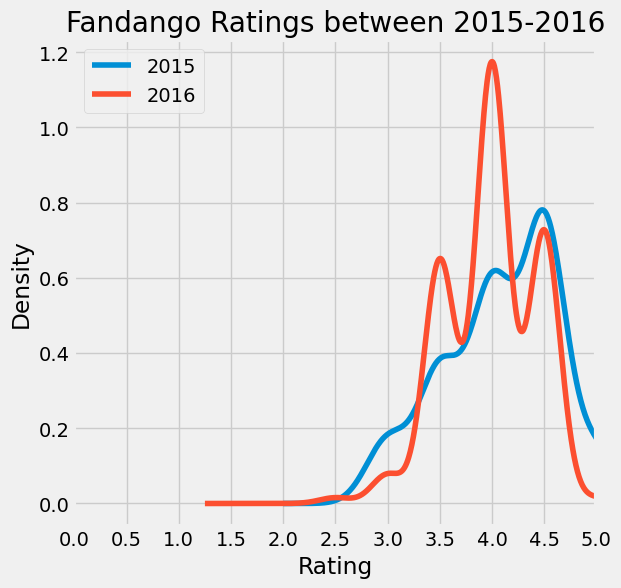

In [49]:
plt.style.use('fivethirtyeight')
pop_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (6,6))
pop_2016['fandango'].plot.kde(label = '2016', legend = True)
plt.title('Fandango Ratings between 2015-2016')
plt.xlabel('Rating')
plt.xlim(0,5)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.show()

- The plot is left skewed
- The 2016 distribution has a lower density in comparison to the 2015 ones

This indicates that there has been a change in Fandango's ranking system after Hickey's analysis. Movies in 2016 are ranked lower

## Comparing Relative Frequencies

### 2015 Frequency Table


In [50]:
pop_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

### 2016 Frequency Table

In [51]:
pop_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2.5     0.581395
3.0     2.906977
3.5    24.418605
4.0    44.186047
4.5    27.325581
5.0     0.581395
Name: fandango, dtype: float64

The above shows that in 2016, there are lower average movie ratings in comparison to 2015.

## Determine the Direction of the Change

In [52]:
# Compute mean for each distribution
pop_2015_mean = pop_2015['Fandango_Stars'].mean()
pop_2016_mean = pop_2016['fandango'].mean()

# Compute median for each distribution
pop_2015_median = pop_2015['Fandango_Stars'].median()
pop_2016_median = pop_2016['fandango'].median()

# Compute mode for each distribution
pop_2015_mode = pop_2015['Fandango_Stars'].mode()[0]
pop_2016_mode = pop_2016['fandango'].mode()[0]

In [53]:
summary = pd.DataFrame()
summary['2015'] = [pop_2015_mean,pop_2015_median,pop_2015_mode]
summary['2016'] = [pop_2016_mean,pop_2016_median,pop_2016_mode]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.982558
median,4.000000,4.000000
mode,4.500000,4.000000


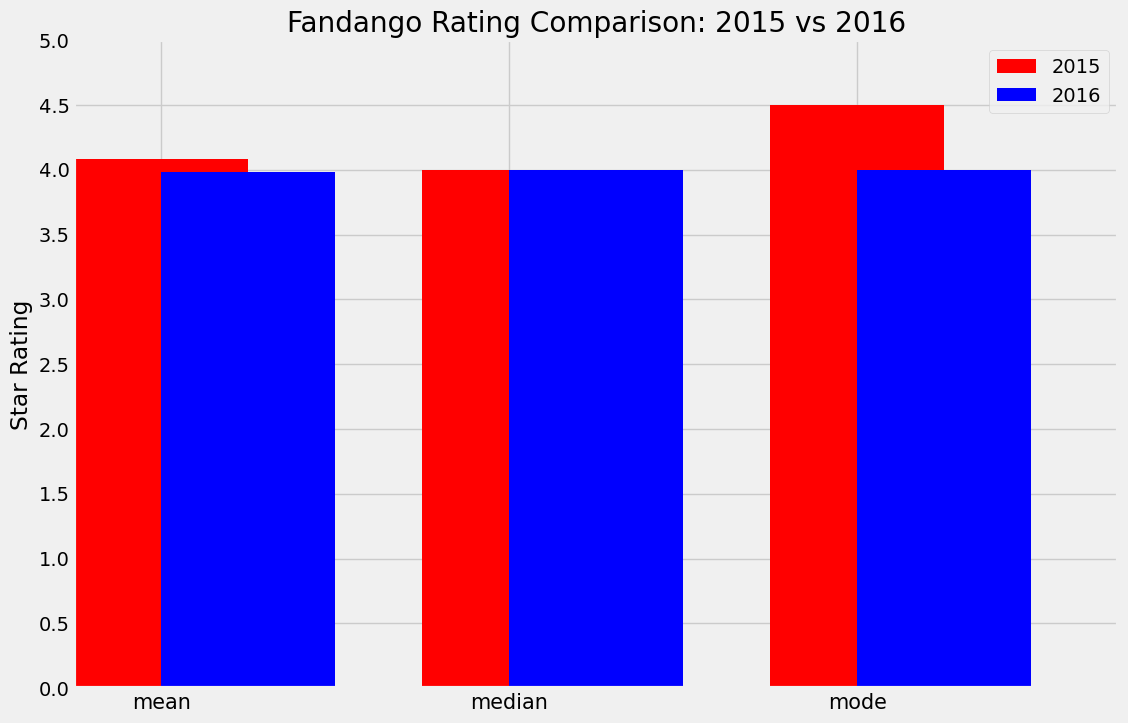

In [56]:
# Plot the distribution
summary['2015'].plot.bar(color = 'red', align = 'center', label = '2015', figsize = (12,8), rot = 90)
summary['2016'].plot.bar(color = 'blue', align = 'edge', label = '2016')
plt.ylabel('Star Rating')
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.title('Fandango Rating Comparison: 2015 vs 2016')
plt.legend()
plt.show()

## Conclusion

Our analysis showed that there is indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. On an average, popular movies released in 2016 were rated slightly lower on Fandango than popular movies released in 2015. This could be an effect of Hickey's analysis.